<a href="https://colab.research.google.com/github/gulnurdeviren/StarFinal/blob/main/star_yeni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving spec_table.d to spec_table.d
     #SpT   Teff  Bp-Rp
24    B9V  10700  0.120
25  B9.5V  10400  0.087
26    A0V   9700  0.037
27    A1V   9300  0.005
28    A2V   8800  0.068
29    A3V   8600  0.110
30    A4V   8250  0.166
31    A5V   8100  0.194
32    A6V   7910  0.222
33    A7V   7760  0.263
Index(['#SpT', 'Teff', 'Bp-Rp'], dtype='object')
---------------------------------Model 1  Performans Değerlendirmesi:-------------------------------
R² Skoru: 0.4118
MAE (Ortalama Mutlak Hata): 1499.2925
MSE (Ortalama Karesel Hata): 3867219.9849
----------------------------------------------------------------------------------------------------
---------------------------------Model 2  Performans Değerlendirmesi:-------------------------------
R² Skoru: 0.9555
MAE (Ortalama Mutlak Hata): 251.3416
MSE (Ortalama Karesel Hata): 292485.5848
----------------------------------------------------------------------------------------------------


/tmp/ipython-input-1037578368.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv('spec_table.d',delim_whitespace=True)


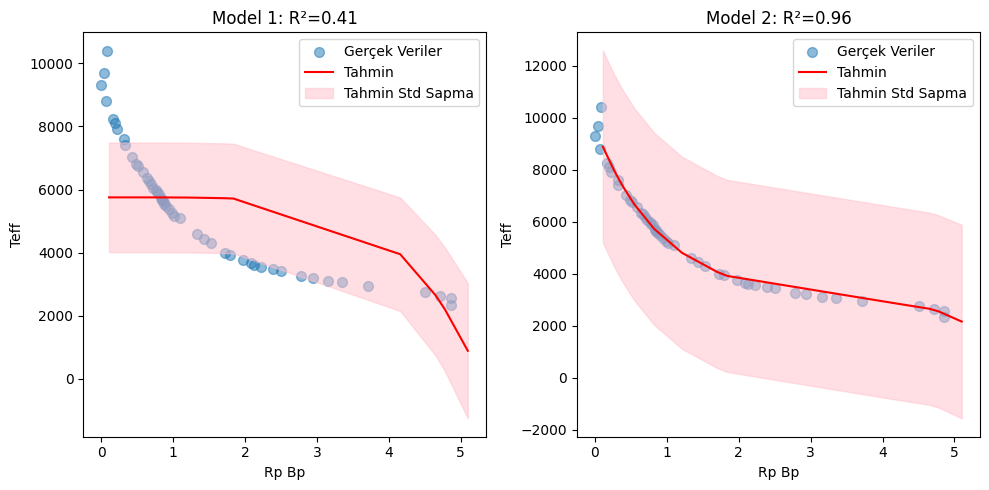

In [21]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

"""
================= KULLANIM KILAVUZU =================
Bu kod, "Bayesian Ridge Regression" yöntemini kullanarak
yıldızların Bp-Rp renk indisinden Teff (etkin sıcaklık)
değerini tahmin eder.
VERİ FORMATI
-----------------------------------
Yüklenecek dosya aşağıdaki gibi olmalıdır (örnek):

    SpT     Teff     Bp-Rp
    O3V     44900    ...
    O4V     42900    ...
    O5V     41400    ...
    F5V      6550    0.587
    F6V      6350    0.640

- 'Teff' sütunu sıcaklık değerlerini,
- 'Bp-Rp' sütunu renk indisini içermelidir.
- Eksik veriler "..." ile gösteriliyor ise, NaN yaparak onları temizlenir.
======================================================
DOSYLAR GitHubda bulunmaktadır URL=https://github.com/gulnurdeviren/StarFinal/tree/main
"""
uploaded = files.upload()
df=pd.read_csv('spec_table.d',delim_whitespace=True)
df.replace("...", np.nan,inplace=True)  # Boş değerleri NaN yapıyoruz bu kısımda
df=df.dropna()
print(df.head(10))
print(df.columns)

x=df['Bp-Rp'].values.astype(float)
y=df['Teff'].values

n_order = 5 #Polinom derecesi n_order ile belirlenir
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #Veriler train/test olarak yüzde 80'e 20 oranında bölünür.

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()


x_train_vander = np.vander(x_train, n_order + 1, increasing=True)
x_test_vander=np.vander(x_test,n_order+1,increasing=True)

reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)


fig,axes=plt.subplots(1,2,figsize=(10,5))

for i, ax in enumerate(axes): #Bayesian Ridge iki farklı alpha ve lambda değeriyle denenir.
  if i == 0:
        init = [1 / np.var(y_train), 1.0]
  elif i == 1:
        init = [0.5, 1e-3]
  reg.set_params(alpha_init=init[0], lambda_init=init[1])

  reg.fit(x_train_vander, y_train)


  y_mean, y_std = reg.predict(x_test_vander, return_std=True)

  r2 = r2_score(y_test, y_mean)
  mae = mean_absolute_error(y_test, y_mean)
  mse = mean_squared_error(y_test, y_mean)
  rmse = np.sqrt(mse)

  print(f"---------------------------------Model {i+1}  Performans Değerlendirmesi:-------------------------------")
  print(f"R² Skoru: {r2:.4f}")
  print(f"MAE (Ortalama Mutlak Hata): {mae:.4f}")
  print(f"MSE (Ortalama Karesel Hata): {mse:.4f}")
  print("-" * 100)

  ax.scatter(x_train_vander[:, 1], y_train, s=50, alpha=0.5, label="Gerçek Veriler")
  sorted_indices = np.argsort(x_test_vander[:, 1])
  ax.plot(x_test_vander[:, 1][sorted_indices], y_mean[sorted_indices], color="red", label="Tahmin")
  ax.fill_between(x_test_vander[:, 1][sorted_indices],
                    y_mean[sorted_indices] - y_std[sorted_indices],
                    y_mean[sorted_indices] + y_std[sorted_indices],
                    color="pink", alpha=0.5, label="Tahmin Std Sapma")
  ax.set_title(f"Model {i+1}: R²={r2:.2f}")
  ax.set_xlabel("Rp Bp")
  ax.set_ylabel("Teff")
  ax.legend()

plt.tight_layout()
plt.show()



In [ ]:
aralık=[(0.0,2.0),(2.0,5.0)] # Bu aralıklarda Bp-Rp arttıkça sıcaklık azalışı farklı bir yol islediği iiçin ikş farklı aralık belirlendi
print("Kesikli Polinom Denklemler:\n")
for low, high in aralık:
    mask = (x >= low) & (x <= high)
    x_sub = x[mask]
    y_sub = y[mask]

    if len(x_sub) == 0:
        continue


    x_vander = np.vander(x_sub, n_order + 1, increasing=True)


    reg.fit(x_vander, y_sub)


    intercept = reg.intercept_
    coef = reg.coef_

    denklem = f"Teff = {intercept:.4f}"
    for d in range(1, len(coef)):
        denklem += f" + {coef[d]:.4f}*(Bp-Rp)^{d}"

    print(f"{low:.1f} ≤ Bp-Rp < {high:.1f} → {denklem}")
    print(sum((x>= 2.0) & (x < 5.0)))


Kesikli Polinom Denklemler:

0.0 ≤ Bp-Rp < 2.0 → Teff = 9743.1131 + -7040.9940*(Bp-Rp)^1 + 2659.0991*(Bp-Rp)^2 + 95.1592*(Bp-Rp)^3 + -217.2872*(Bp-Rp)^4
17
2.0 ≤ Bp-Rp < 5.0 → Teff = 4859.1213 + -195.8635*(Bp-Rp)^1 + -428.0821*(Bp-Rp)^2 + 146.6607*(Bp-Rp)^3 + -14.6265*(Bp-Rp)^4
17



--- Manuel Bp-Rp Tahmini ---
Bir Bp-Rp değeri girin (örneğin 1.2): 1.2
Tahmin edilen Teff : 4821.93 K


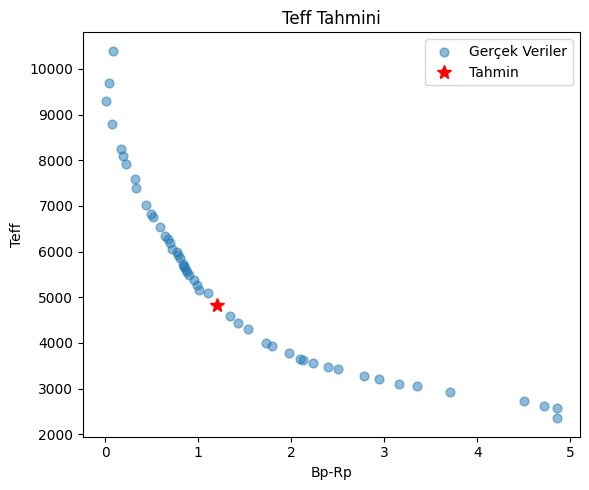

In [5]:
# --- TEK Bp-Rp DEĞERİ İÇİN TAHMİN -> Bu kısımda girilen tek bir Rp-Bp değerine karşılık modele bir Teff tahmini yaptırılmıştı ---
# Daha sonrasında asıl  veri kümemizin üzerine yazdırılarak bu tahminin gerçekliğe uygunluğu gösterilmiştir
print("\n--- Manuel Bp-Rp Tahmini ---")
user_input = float(input("Bir Bp-Rp değeri girin (örneğin 1.2): "))


user_input_vander = np.vander([user_input], n_order + 1, increasing=True)

reg.fit(x_train_vander, y_train)
predicted_teff = reg.predict(user_input_vander)[0]
print(f"Tahmin edilen Teff : {predicted_teff:.2f} K")

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(x_train_vander[:, 1], y_train, s=40, alpha=0.5, label="Gerçek Veriler")
x_star = user_input_vander[0][1]
ax.plot(x_star, predicted_teff, 'r*', markersize=10, label="Tahmin")


ax.set_title("Teff Tahmini")
ax.set_xlabel("Bp-Rp")
ax.set_ylabel("Teff")
ax.legend()

plt.tight_layout()
plt.show()


Saving kumeler2_bprp.txt to kumeler2_bprp (1).txt


/tmp/ipython-input-1616550364.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_kume = pd.read_csv("kumeler2_bprp.txt",


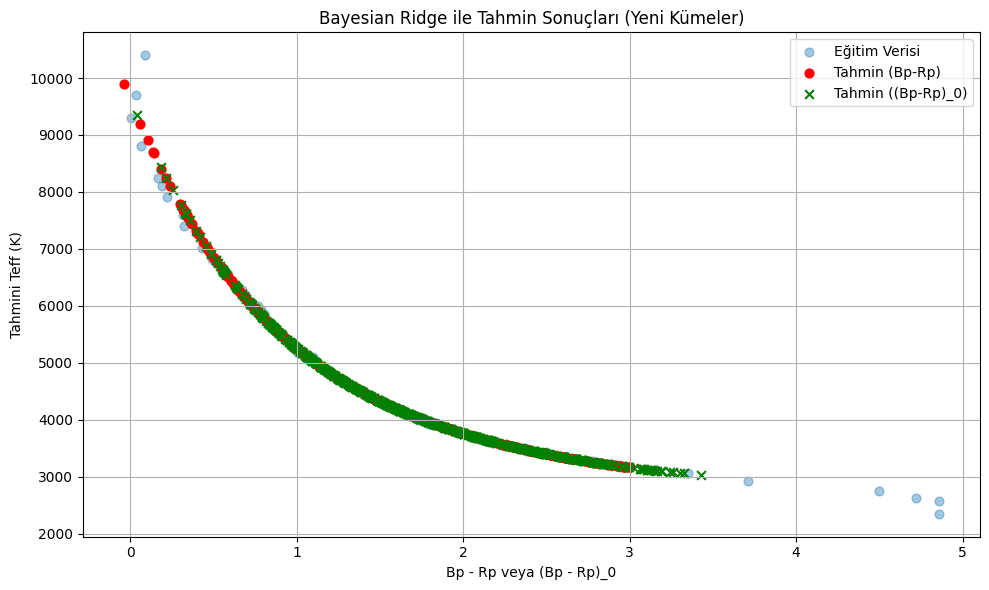

In [23]:
"""
================= YENİ KÜME VERİSİNDEN TAHMİN =================

- Daha önce eğittiğiMiz BayesianRidge modelini (reg) kullanarak,
  'kumeler2_bprp.txt' içindeki Bp-Rp ve (Bp-Rp)_0 sütunları için Teff tahminleri üretmek,
  sonuçları ana verimizim üzerine tabloya eklemek ve görselleştirmektir.
=======================================================================
"""

uploaded5 = files.upload()# Bu dosyada aynı şekilde GitHub'da bulunmaktadır
df_kume = pd.read_csv("kumeler2_bprp.txt",
                      delim_whitespace=True,
                      comment='U',
                      header=None,
                      names=["(Bp-Rp)_0", "Bp-Rp"])

# Sadece sayısal değerlere sahip satırları alıyoruz
df_kume = df_kume[pd.to_numeric(df_kume["Bp-Rp"], errors="coerce").notna()]
df_kume = df_kume.astype(float)


bp_rp0_vals = df_kume["(Bp-Rp)_0"].values
bp_rp_vals = df_kume["Bp-Rp"].values

#  vander matrislerini oluşturuyoruz
bp_rp0_vander = np.vander(bp_rp0_vals, N=n_order + 1, increasing=True)
bp_rp_vander = np.vander(bp_rp_vals, N=n_order + 1, increasing=True)

# Hem Bp-Rp ,için hem de Bp-Rp _0 için tahminleri al
teff_pred_bp_rp0 = reg.predict(bp_rp0_vander)
teff_pred_bp_rp = reg.predict(bp_rp_vander)

# Tahminleri dataframe'e ekle
df_kume["Teff_Tahmin_(Bp-Rp)_0"] = teff_pred_bp_rp0
df_kume["Teff_Tahmin_Bp-Rp"] = teff_pred_bp_rp

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, s=40, alpha=0.4, label="Eğitim Verisi")
plt.scatter(bp_rp_vals, teff_pred_bp_rp, color='red', s=40, marker='o', label='Tahmin (Bp-Rp)')
plt.scatter(bp_rp0_vals, teff_pred_bp_rp0, color='green', s=40, marker='x', label='Tahmin ((Bp-Rp)_0)')

plt.xlabel("Bp - Rp veya (Bp - Rp)_0")
plt.ylabel("Tahmini Teff (K)")
plt.title("Bayesian Ridge ile Tahmin Sonuçları (Yeni Kümeler)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
"""
================= İSTEĞE BAĞLI OLARAK TAHMİNLERİ DOSYAYA EKLEME KILAVUZU =================

- Daha önce hesaplanan Teff tahminlerini, orijinal 'kumeler2_bprp.txt'
  dosyasındaki satırların yanına ekleyerek yeni bir çıktı dosyası üretmek.
  Bu kod hücresi yine diğer dosyaların formatına gööre düzenlenip onlar için de çıktı dosyası üretilebilir
"""
teff_bp_rp = teff_pred_bp_rp.round(6)
teff_bp_rp0 = teff_pred_bp_rp0.round(6)


with open("kumeler2_bprp.txt", "r") as f:
    original_lines = f.readlines()

output_lines = []
pred_index = 0  # Tahmin sırasını takip et


output_lines.append("Bp-Rp_0 Bp-Rp Teff_Tahmin_(bp-rp)0 Teff_Tahmin_bp-rp")

for line in original_lines:
    stripped = line.strip()

    # Eğer başlık, boşluk ya da küme adıysa aynen ekle
    if stripped == "" or stripped.startswith("UPK") or "Bp-Rp" in stripped or "bp-rp" in stripped:
        output_lines.append(stripped)
        continue

    try:
        # (Bp-Rp)_0 ve Bp-Rp
        val1, val2 = map(float, stripped.split())  # val1: (Bp-Rp)_0, val2: Bp-Rp

        # Tahminleri sıraya uygun şekilde yazarız
        out_line = f"{val1:.9f} {val2:.6f} {teff_bp_rp0[pred_index]:.6f} {teff_bp_rp[pred_index]:.6f}"
        output_lines.append(out_line)
        pred_index += 1
    except:

        output_lines.append(stripped)


output_path = "kumeler2_tahminli.txt"
with open(output_path, "w") as f:
    for line in output_lines:
        f.write(line + "\n")

print(f"✔ Tahminli dosya başarıyla yazıldı: {output_path}")


Tahminli dosya başarıyla yazıldı: kumeler2_tahminli.txt


Saving kümeler_(bp-rp)_(bp-rp)0=.txt to kümeler_(bp-rp)_(bp-rp)0= (2).txt


/tmp/ipython-input-2086020465.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_new = pd.read_csv("kümeler_(bp-rp)_(bp-rp)0=.txt",  delim_whitespace=True, comment='U', header=None, names=["bp-rp", "(bp-rp)0"])


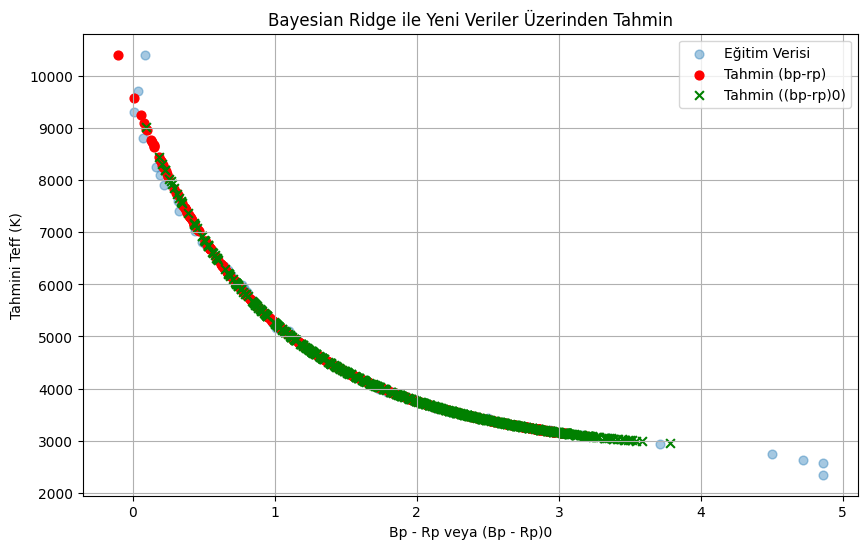

In [31]:
"""
================= YENİ KÜME VERİSİNDEN TAHMİN =================

- Daha önce eğittiğiMiz BayesianRidge modelini (reg) kullanarak,
  'kümeler_(bp-rp)_(bp-rp)0=.txt' içindeki Bp-Rp ve (Bp-Rp)0 sütunları için Teff tahminleri üretmek,
  sonuçları ana verimizim üzerine tabloya eklemek ve görselleştirmektir.
  Yukarıdaki diğer test dosyası şle aynı işlemler yapılarark tahminler test edilmiştir.
=======================================================================
"""
uploaded4 = files.upload()
df_new = pd.read_csv("kümeler_(bp-rp)_(bp-rp)0=.txt",  delim_whitespace=True, comment='U', header=None, names=["bp-rp", "(bp-rp)0"])
df_new = df_new[pd.to_numeric(df_new["bp-rp"], errors="coerce").notna()]

df_new = df_new.astype(float)

bp_rp_raw = df_new['bp-rp'].values.astype(float)
bp_rp0_raw = df_new['(bp-rp)0'].values.astype(float)

bp_rp_vander = np.vander(bp_rp_raw, N=n_order + 1, increasing=True)
bp_rp0_vander = np.vander(bp_rp0_raw, N=n_order + 1, increasing=True)

teff_pred_bp_rp = reg.predict(bp_rp_vander)
teff_pred_bp_rp0 = reg.predict(bp_rp0_vander)

# Veriye ekleyelim
df_new["Teff_Tahmin_bp-rp"] = teff_pred_bp_rp
df_new["Teff_Tahmin_(bp-rp)0"] = teff_pred_bp_rp0
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, s=40, alpha=0.4, label="Eğitim Verisi")
plt.scatter(bp_rp_raw, teff_pred_bp_rp, color='red', label='Tahmin (bp-rp)', s=40, marker='o')
plt.scatter(bp_rp0_raw, teff_pred_bp_rp0, color='green', label='Tahmin ((bp-rp)0)', s=40, marker='x')

plt.xlabel("Bp - Rp veya (Bp - Rp)0")
plt.ylabel("Tahmini Teff (K)")
plt.title("Bayesian Ridge ile Yeni Veriler Üzerinden Tahmin")
plt.legend()
plt.grid(True)
plt.show()


In [36]:

"""
================= İSTEĞE BAĞLI OLARAK TAHMİNLERİ DOSYAYA EKLEME KILAVUZU =================

- Daha önce hesaplanan Teff tahminlerini, orijinal 'kümeler_(bp-rp)_(bp-rp)0=.txt'
  dosyasındaki satırların yanına ekleyerek yeni bir çıktı dosyası üretmek.
  Bu kod hücresi yine diğer dosyaların formatına gööre düzenlenip onlar için de çıktı dosyası üretilebilir
"""
# Dosyayı okuma kısmı
with open("kümeler_(bp-rp)_(bp-rp)0=.txt", "r") as f:
    original_lines = f.readlines()

teff_bp_rp = teff_pred_bp_rp.round(6)
teff_bp_rp0 = teff_pred_bp_rp0.round(6)

output_lines = []
pred_index = 0  # tahmin indeks takibi


output_lines.append("bp-rp (bp-rp)0 Teff_Tahmin_bp-rp Teff_Tahmin_(bp-rp)0")

for line in original_lines:
    stripped = line.strip()

    # Eğer satır boşsa ya da yazı varsa, dokunmayız
    if stripped == "" or stripped.startswith("UPK") or "bp-rp" in stripped:
        output_lines.append(stripped)
        continue

    try:

        bp_rp_val, bp_rp0_val = map(float, stripped.split())
        # Tahminleri ekleriz
        out_line = f"{bp_rp_val:.6f} {bp_rp0_val:.9f} {teff_bp_rp[pred_index]:.6f} {teff_bp_rp0[pred_index]:.6f}"
        output_lines.append(out_line)
        pred_index += 1
    except:
        # Sayıya çevrilemiyorsa aynen ekle
        output_lines.append(stripped)


with open("kümeler_tahminli.txt", "w") as f:
    for line in output_lines:
        f.write(line + "\n")


Saving yeniveriseti_1denaz.txt to yeniveriseti_1denaz.txt


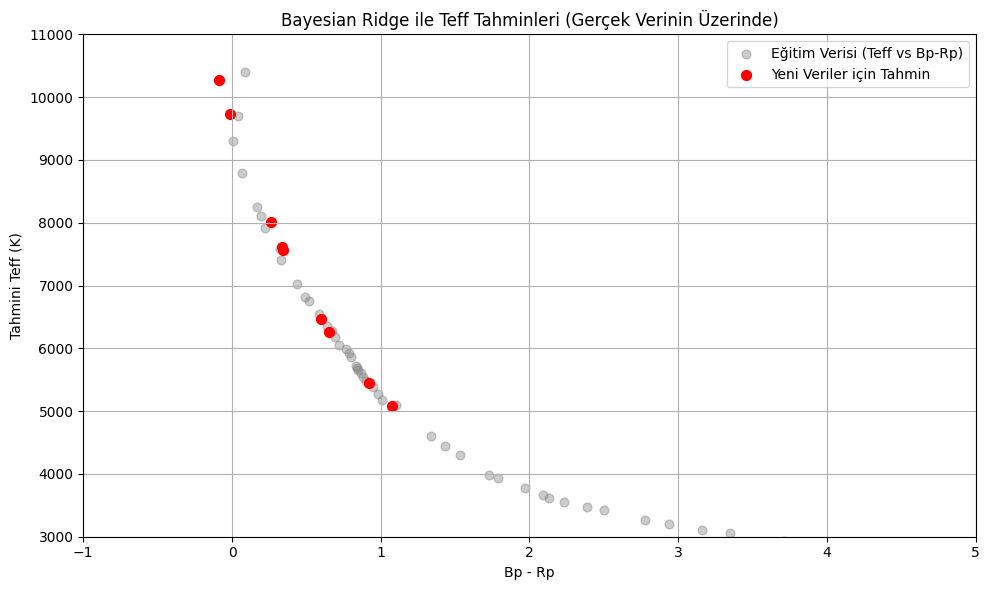

[10279.82855809  7618.20802381  7558.54671549  9736.82964926
  8009.20178948  5085.50858479  6466.85623979  5450.11912946
  6263.60675302]


In [37]:
"""
================= YENİ VERİDEN TAHMİN ve GRAFİK KILAVUZU =================
- Eğitilmiş BayesianRidge modelini (reg) ve eğitimde kullandığım n_order değerini
  kullanarak 'yeniveriseti_1denaz.txt' içindeki Bp-Rp değerleri (1 den küçük olan) için Teff tahmini üretip,
  tahminleri tabloya eklenip gerçek eğitim noktalarının üstüne çizdirilmiştir.

"""
uploaded3 = files.upload()
df_bprp = pd.read_csv("yeniveriseti_1denaz.txt")

bprp_new = df_bprp["Bp-Rp"].values.astype(float)
bprp_vander_new = np.vander(bprp_new, N=n_order + 1, increasing=True)

# Tahmin
teff_new = reg.predict(bprp_vander_new)
df_bprp["Teff_Tahmini_BayesRidge"] = teff_new


plt.figure(figsize=(10, 6))
plt.scatter(x_train_vander[:, 1], y_train, s=40, alpha=0.4, color="gray", label="Eğitim Verisi (Teff vs Bp-Rp)")


plt.scatter(bprp_new, teff_new, color='red', s=50, label="Yeni Veriler için Tahmin")


plt.xlabel("Bp - Rp")
plt.ylabel("Tahmini Teff (K)")
plt.title("Bayesian Ridge ile Teff Tahminleri (Gerçek Verinin Üzerinde)")
plt.xlim(-1.0, 5.0)
plt.ylim(3000, 11000)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(teff_new)

Yeni BPRP Değerlerinden ilk 10 tanesi: [1.213162 1.634713 1.646241 1.285448 1.559064 2.373485 1.899803 2.222703
 1.955987]


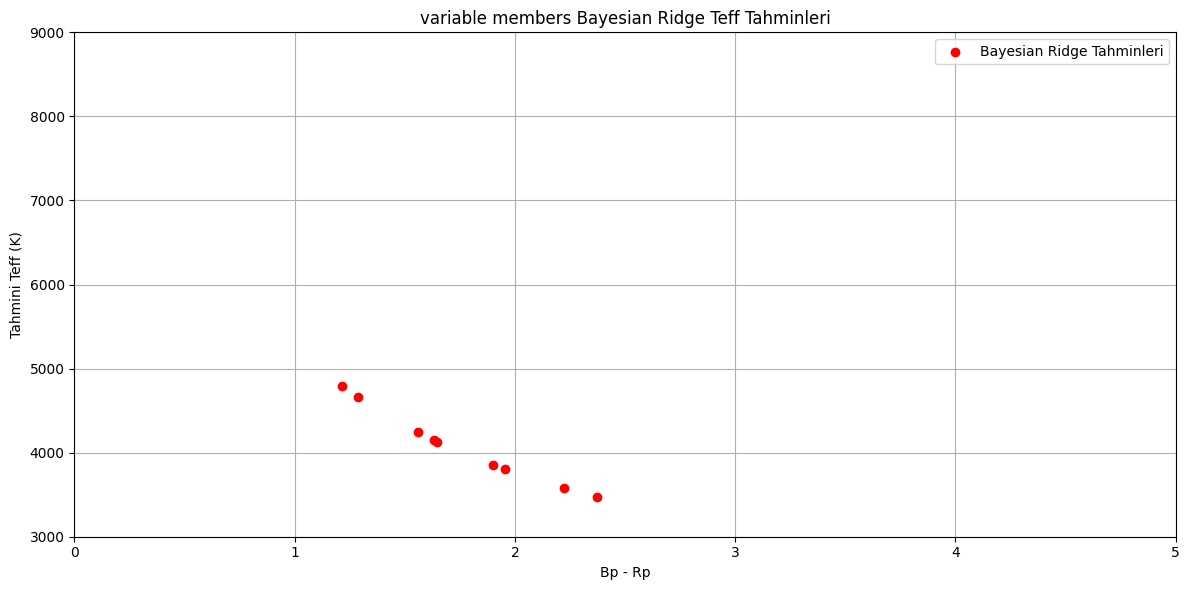

[4796.61407583 4144.66311732 4130.43069624 4663.71801113 4242.13824815
 3476.92182585 3853.58144946 3580.8854772  3800.46649896]


In [40]:
"""
================= YENİ VERİDEN TAHMİN ve GRAFİK KILAVUZU =================
- Eğitilmiş BayesianRidge modelini (reg) ve eğitimde kullandığım n_order değerini
  kullanarak 'variable_members.dat' içindeki Bp-Rp değerleri (1 ile 2 arasında )için Teff tahmini üretip,
  tahminleri tabloya çizdirilmiştir.

"""
uploaded2 = files.upload()

# İlk 15 sütunu kullanırız
column_names = [
    "id", "RA", "Dec", "pmRA", "epmRA", "pmDec", "epmDec",
    "Plx", "ePlx", "Gmag", "eGmag", "BPmag", "eBPmag", "RPmag", "eRPmag"
]
df_var = pd.read_csv(
    'variable_members.dat',
    sep=r'\s+',
    header=None,
    names=column_names,
    usecols=range(15),
    skiprows=1            # İlk satırı atla
)
# Test verisini oluştururuz Bp-Rp ile
df_var["Bp-Rp"] = df_var["BPmag"] - df_var["RPmag"]
df_var["Hata"] = 0.05
bprp = df_var[["Bp-Rp", "Hata"]].copy()


bprp_ = bprp["Bp-Rp"].values.astype(float)
print("Yeni BPRP Değerlerinden ilk 10 tanesi:", bprp_[:10])

bprp_vander = np.vander(bprp_, n_order + 1, increasing=True)
teff_ = reg.predict(bprp_vander)


bprp["Teff_Tahmini_BayesRidge"] = teff_
plt.figure(figsize=(12, 6))
plt.scatter(bprp_, teff_, color='red', label='Bayesian Ridge Tahminleri')
plt.xlabel("Bp - Rp")
plt.ylabel("Tahmini Teff (K)")
plt.title("variable members Bayesian Ridge Teff Tahminleri")
plt.xlim(0.0, 5.0)
plt.ylim(3000, 9000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(teff_)
# Dosyaya yazdırmak istersek eğer aşağıdaki komutları kullanabilriz
#bprp.to_csv("bayesian_ridge_teff_predictions.csv", index=False)

#print("Tahminler 'bayesian_ridge_teff_predictions.csv' dosyasına kaydedildi.")


Saving UPK_220.gaia to UPK_220.gaia
  id RA Dec pmRA epmRA pmDec epmDec Plx ePlx Gmag eGmag BPmag eBPmag RPmag eRPmag probs_final
0  id RA Dec pmRA epmRA pmDec epmDec Plx ePlx Gma...                                         
1  104 350.02681639545 66.24882164268 -2.432 0.61...                                         
2  110 350.44714765867 66.56156012588 -2.598 0.22...                                         
3  12 351.9113703792 66.64394200622 -3.403 0.167 ...                                         
4  13 350.32291275884 66.59659584481 -3.049 0.28 ...                                         
Index(['id RA Dec pmRA epmRA pmDec epmDec Plx ePlx Gmag eGmag BPmag eBPmag RPmag eRPmag probs_final'], dtype='object')
Yeni BPRP Değerlerinden ilk 10 tanesi: [1.680128 2.580133 2.588924 2.580906 2.488342 1.740373 2.596641 1.596422
 2.120093 1.8088  ]


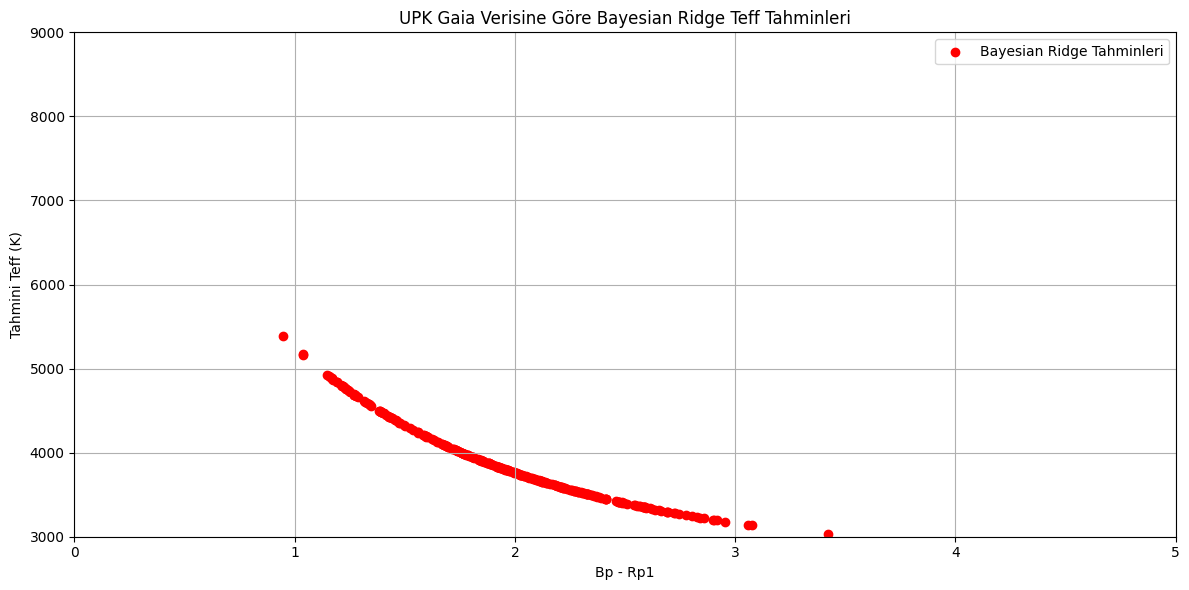

In [41]:
"""
================= YENİ VERİDEN TAHMİN ve GRAFİK KILAVUZU =================
- Eğitilmiş BayesianRidge modelini (reg) ve eğitimde kullandığım n_order değerini
  kullanarak 'UPK_220.gaia' içindeki Bp-Rp değerleri (1 ile 3 arasında) için Teff tahmini üretip,
  tahminleri tabloya çizdirilmiştir.

"""
uploaded1 = files.upload()


df_upk = pd.read_fwf('UPK_220.gaia')


print(df_upk.head())
print(df_upk.columns)

column_names = [
    "id", "RA", "Dec", "pmRA", "epmRA", "pmDec", "epmDec",
    "Plx", "ePlx", "Gmag", "eGmag", "BPmag", "eBPmag",
    "RPmag", "eRPmag", "probs_final"
]

# UPK dosyasını okuma
df_upk = pd.read_csv(
    'UPK_220.gaia',
    sep=r'\s+',
    names=column_names + ["label"],
    skiprows=2
    )

# Test verisini oluşturma
df_upk["Bp-Rp1"] = df_upk["BPmag"] - df_upk["RPmag"]
df_upk["Hata"] = 0.05
bprp = df_upk[["Bp-Rp1", "Hata"]].copy()

#bprp_values değişkenini güncelle ve yazdırma
bprp_values = bprp["Bp-Rp1"].values.astype(float)
print("Yeni BPRP Değerlerinden ilk 10 tanesi:", bprp_values[:10])
# Vandermonde matrisi ve tahminler
bprp_vander = np.vander(bprp_values, n_order + 1, increasing=True)
teff_pred = reg.predict(bprp_vander)


bprp["Teff_Tahmini_BayesRidge"] = teff_pred
plt.figure(figsize=(12, 6))
plt.scatter(bprp_values, teff_pred, color='red', label='Bayesian Ridge Tahminleri')
plt.xlabel("Bp - Rp1")
plt.ylabel("Tahmini Teff (K)")
plt.title("UPK Gaia Verisine Göre Bayesian Ridge Teff Tahminleri")
plt.xlim(0.0, 5.0)
plt.ylim(3000, 9000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
!pip install numpyro --quiet
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 11.4 MB/s eta 0:00:00


sample: 100%|██████████| 6000/6000 [00:09<00:00, 651.04it/s, 319 steps of size 1.91e-02. acc. prob=0.94]


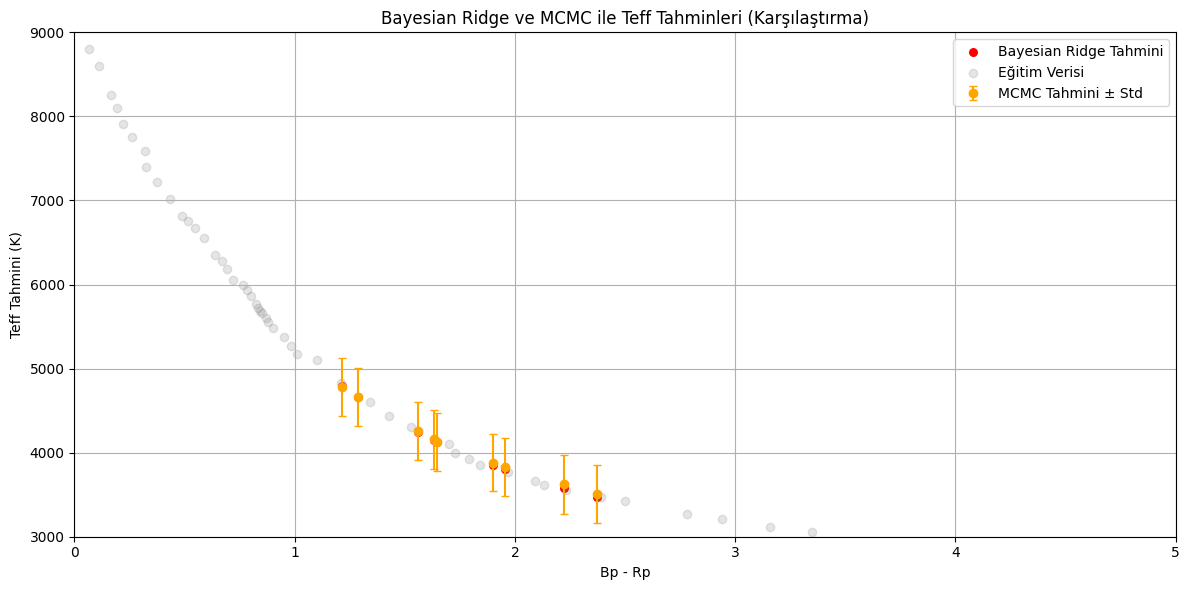

In [43]:
"""
================= MCMC ile Teff Tahmini =================

- Bp−Rp’den üretilen polinom özellikleri (Vandermonde) üzerinden,
  JAX+NumPyro ile MCMC kullanarak Teff için posterior tahmin dağılımını elde edilmiş
  ve belirsizlik bantları ile görselleştirilmiştir.

- mean_pred : Posterior tahmin ortalaması (Kelvin)
- std_pred  : Posterior tahmin std sapması (Kelvin)
- teff_lower/upper : Ortalama ±1σ aralıkları
"""
x_scaler = StandardScaler()
x_scaled = x_scaler.fit_transform(x.reshape(-1, 1)).flatten()
bprp_scaled = x_scaler.transform(bprp_.reshape(-1, 1)).flatten()

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

x_train_jax = jnp.array(np.vander(x_scaled, n_order + 1, increasing=True))
y_train_jax = jnp.array(y_scaled)
x_test_jax = jnp.array(np.vander(bprp_scaled, n_order + 1, increasing=True))


def model(X, Y=None):
    n_features = X.shape[1]
    w = numpyro.sample("w", dist.Normal(0, 10).expand([n_features]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.0))
    mean = jnp.dot(X, w)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(mean, sigma), obs=Y)


nuts_kernel = NUTS(model)
mcmc_new = MCMC(nuts_kernel, num_warmup=3000, num_samples=3000)
mcmc_new.run(jax.random.PRNGKey(0), X=x_train_jax, Y=y_train_jax)


predictive = Predictive(model, posterior_samples=mcmc_new.get_samples(), return_sites=["obs"])
predictions = predictive(jax.random.PRNGKey(1), X=x_test_jax)
teff_samples = predictions["obs"]

mean_pred_scaled = np.mean(teff_samples, axis=0)
std_pred_scaled = np.std(teff_samples, axis=0)


mean_pred = y_scaler.inverse_transform(mean_pred_scaled.reshape(-1, 1)).flatten()
std_pred = std_pred_scaled * y_scaler.scale_[0]


plt.figure(figsize=(12, 6))
plt.scatter(bprp_, teff_, color='red', label='Bayesian Ridge Tahmini', s=30)

plt.errorbar(bprp_, mean_pred, yerr=std_pred, fmt='o', color='orange', label='MCMC Tahmini ± Std', capsize=3)
plt.scatter(x, y, alpha=0.2, label='Eğitim Verisi', color='gray')

plt.xlabel("Bp - Rp")
plt.ylabel("Teff Tahmini (K)")
plt.title("Bayesian Ridge ve MCMC ile Teff Tahminleri (Karşılaştırma)")
plt.xlim(0, 5)
plt.ylim(3000, 9000)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
teff_lower = mean_pred - std_pred
teff_upper = mean_pred + std_pred

df_out = pd.DataFrame({
    "Bp-Rp": bprp_,
    "Teff_Mean": mean_pred,
    "Teff_Lower": teff_lower,
    "Teff_Upper": teff_upper
})


df_out.to_csv("mcmc_teff_predictions.csv", index=False)



sample: 100%|██████████| 6000/6000 [00:28<00:00, 212.26it/s, 1023 steps of size 1.23e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.16      0.02      0.16      0.13      0.18    349.15      1.01
      w[0]      2.09      0.07      2.09      1.97      2.19    176.87      1.00
      w[1]     -3.68      0.31     -3.68     -4.14     -3.16     86.44      1.01
      w[2]      2.06      0.45      2.06      1.29      2.70     72.56      1.01
      w[3]     -0.66      0.25     -0.65     -1.04     -0.26     70.27      1.01
      w[4]      0.11      0.06      0.11      0.02      0.20     71.12      1.01
      w[5]     -0.01      0.00     -0.01     -0.01      0.00     73.31      1.01

Number of divergences: 0


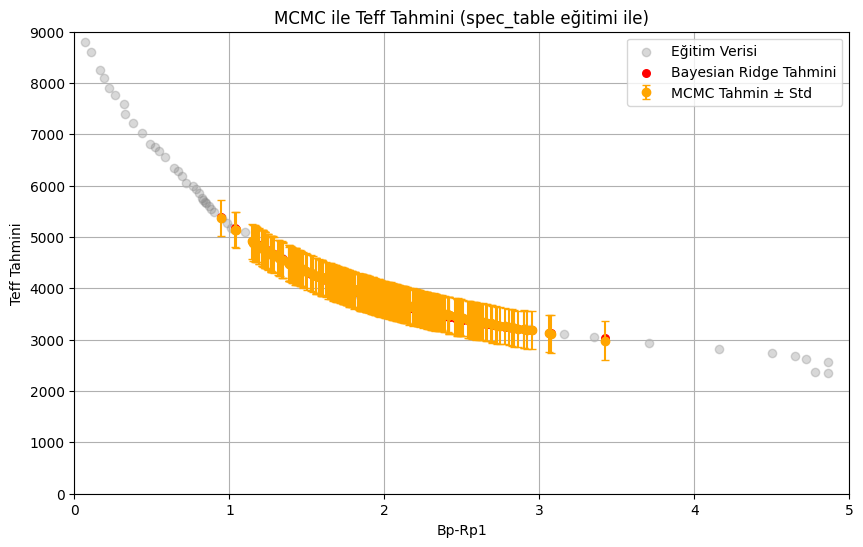

In [44]:
"""
================= MCMC ile Teff Tahmini =================

- Bp−Rp’den üretilen polinom özellikleri (Vandermonde) üzerinden,
  JAX+NumPyro ile MCMC kullanarak Teff için posterior tahmin dağılımını elde edilmiş
  ve belirsizlik bantları ile görselleştirilmiştir.
"""
scaler = StandardScaler()

bprp_values = bprp["Bp-Rp1"].values.astype(float)
x_scaled_var = scaler.fit_transform(x.reshape(-1, 1)).flatten()

bprp_scaled_var = scaler.transform(bprp_values.reshape(-1, 1)).flatten()

y_scaler_var = StandardScaler()
y_scaled_var = y_scaler_var.fit_transform(y.reshape(-1, 1)).flatten()


x_test_vander_var = np.vander(bprp_scaled_var, n_order + 1, increasing=True)
x_test_jax_var = jnp.array(x_test_vander_var)

def model(X, Y=None):
    n_features = X.shape[1]
    w = numpyro.sample("w", dist.Normal(0, 10).expand([n_features]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.0))
    mean = jnp.dot(X, w)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(mean, sigma), obs=Y)



x_train_vander_var = np.vander(x, n_order + 1, increasing=True)
x_train_jax_var = jnp.array(x_train_vander_var)
y_train_jax_var = jnp.array(y_scaled_var)


nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=3000, num_samples=3000)
mcmc.run(jax.random.PRNGKey(0), X=x_train_jax_var, Y=y_train_jax_var)
mcmc.print_summary()


x_test_vander_var = np.vander(bprp_values, n_order + 1, increasing=True)
x_test_jax_var = jnp.array(x_test_vander_var)


predictive = Predictive(model, posterior_samples=mcmc.get_samples(), return_sites=["obs"])
predictions = predictive(jax.random.PRNGKey(1), X=x_test_jax_var)
teff_samples = predictions["obs"]


mean_pred_scaled = np.mean(teff_samples, axis=0)
std_pred_scaled = np.std(teff_samples, axis=0)

mean_pred = y_scaler_var.inverse_transform(mean_pred_scaled.reshape(-1, 1)).flatten()
std_pred = std_pred_scaled * y_scaler_var.scale_[0]  # std için sadece scale çarpılır

bprp["teffTahminleri_MCMC"] = mean_pred
bprp["stdSapma"] = std_pred
std_pred

plt.figure(figsize=(10, 6))
plt.errorbar(bprp_values, mean_pred, yerr=std_pred,
             fmt='o', label="MCMC Tahmin ± Std", color='orange', capsize=3)
plt.xlabel("Bp-Rp1")
plt.scatter(x, y, alpha=0.3, label="Eğitim Verisi", color='gray')
plt.scatter(bprp_values, teff_pred, color='red', label='Bayesian Ridge Tahmini', s=30)
plt.ylabel("Teff Tahmini")
plt.title("MCMC ile Teff Tahmini (spec_table eğitimi ile)")
plt.legend()
plt.grid(True)
plt.xlim(0, 5.0)
plt.ylim(0, 9000)
plt.show()


In [45]:
!pip install corner


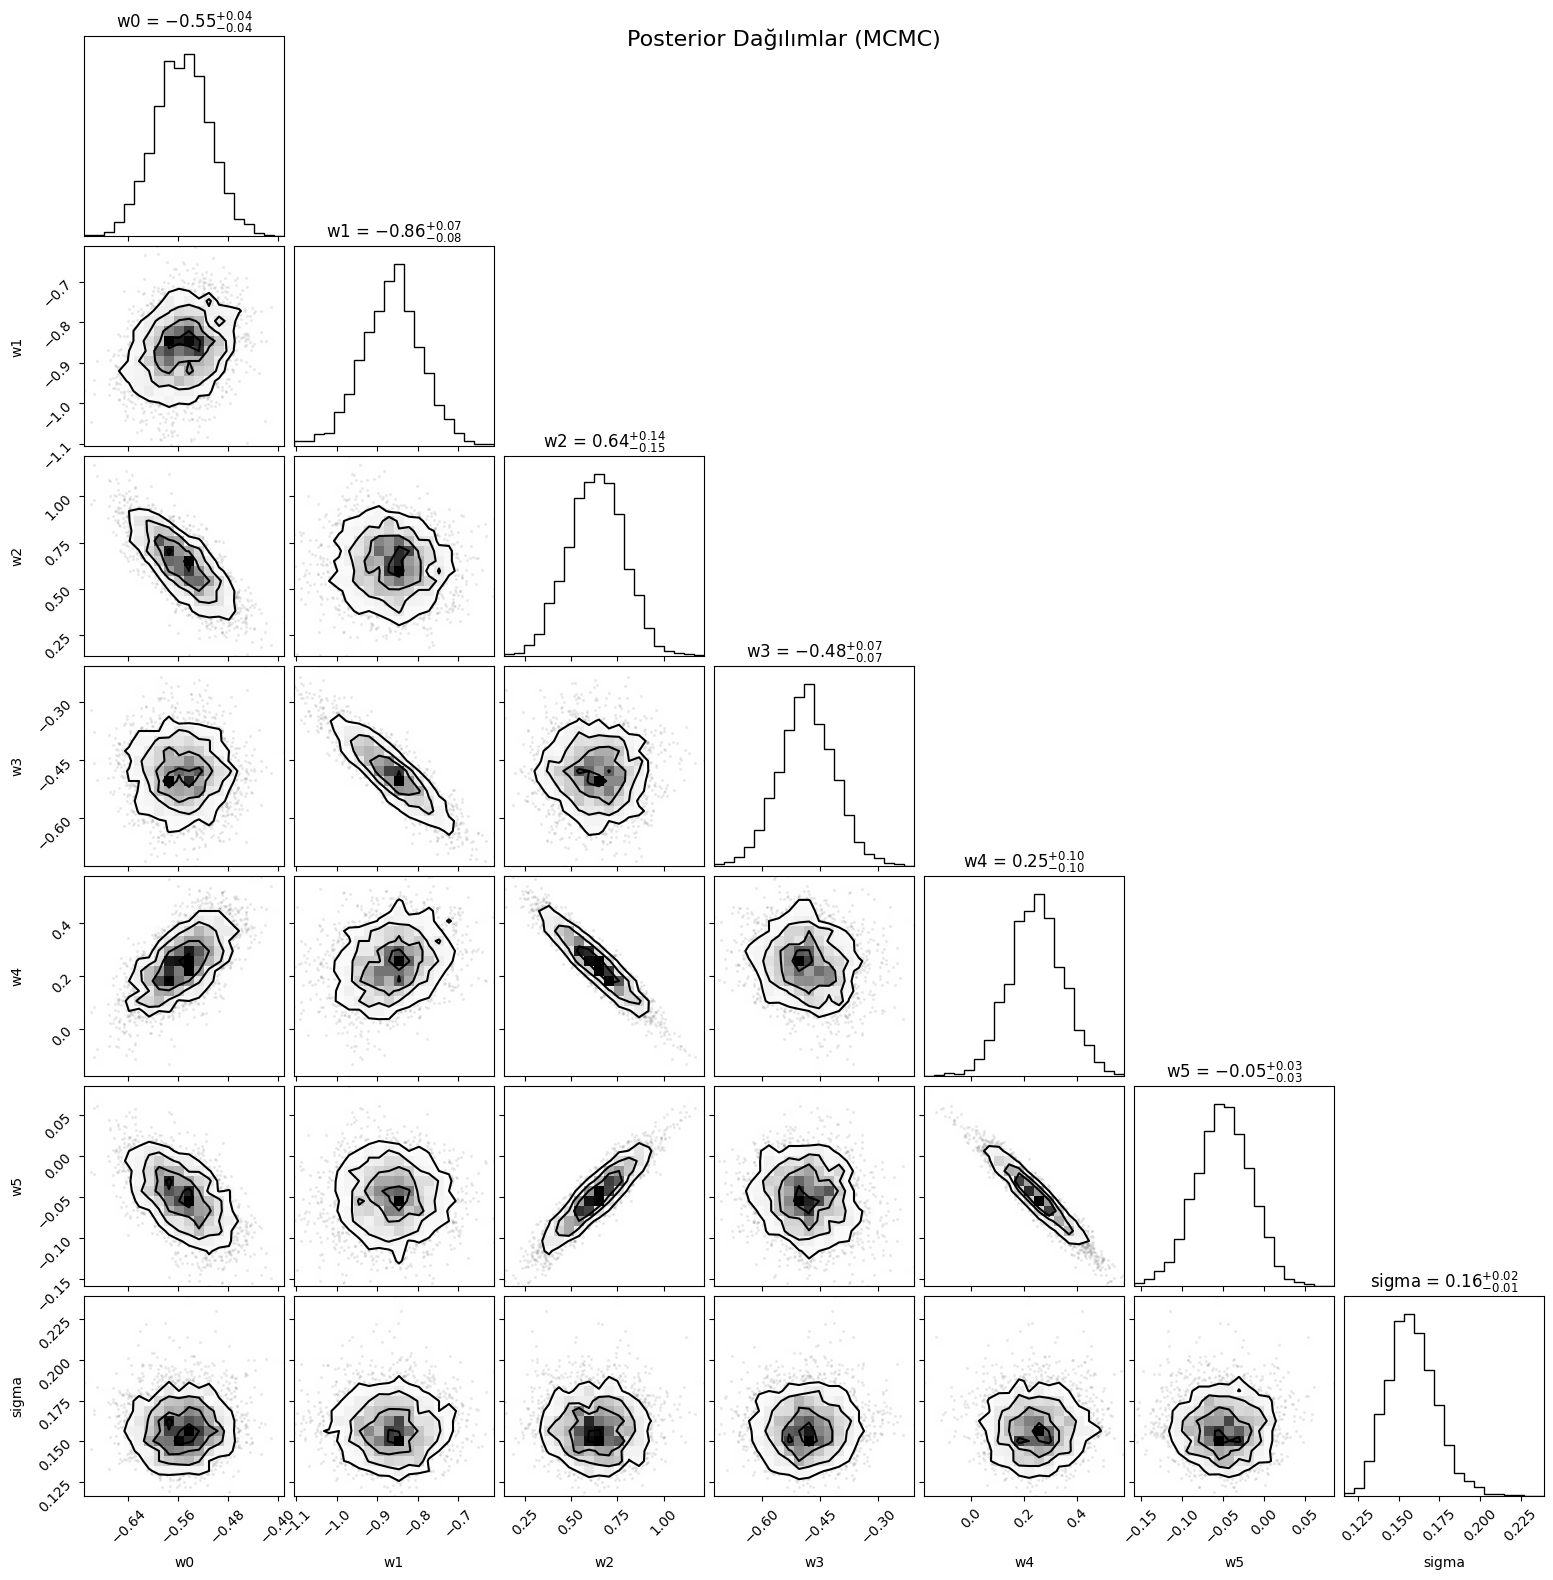

In [46]:
"""
================= MCMC POSTERIOR GÖRSELLEŞTİRME =================
- NumPyro MCMC çıktısından (mcmc_new) alınan posterior örnekleriyle
  parametre marjinal dağılımlarını (histogram) ve ikili ortak dağılımları
  (contour) corner plot ile görselleştirilmiştir.
"""
import arviz as az
import corner
import numpy as np
# Posterior örnekleri
samples = mcmc_new.get_samples()
w_samples = samples["w"]
sigma_samples = samples["sigma"].reshape(-1, 1)

# Hepsini birleştir
corner_data = np.hstack([w_samples, sigma_samples])
labels = [f"w{i}" for i in range(w_samples.shape[1])] + ["sigma"]


corner.corner(corner_data, labels=labels, show_titles=True, title_kwargs={"fontsize": 12})
plt.suptitle("Posterior Dağılımlar (MCMC)", fontsize=16)
plt.show()


In [48]:
"""
================= OLUŞTURDUĞUMUZ PARÇALI POLİNOM FONKSİYONU iLE Teff HESAPLAMA =================
- Bp−Rp renk aralığını ikiye ayırarak (0–2 ve 2–5),
  her aralık için ayrı polinom denkleminden Teff hesaplanmışır.

"""
bp_rp_new = np.arange(0, 5.0, 0.02)

def teff_func(bp_rp):
    if isinstance(bp_rp, (int, float)):
        # Tek değer girildiyse
        bp_rp = np.array([bp_rp])
    teff_values = []
    for x in bp_rp:
        if 0.0 <= x < 2.0:#Eğer Bp−Rp 0.0 ≤ x < 2.0 → sıcak yıldızlar için bu polinom kullanıyoruz
            teff = (
                9795.7886
                + (-7563.6662) * x
                + 3800.2697 * (x ** 2)
                + (-779.4585) * (x ** 3)
            )
        elif 2.0 <= x <= 5.0:#Eğer 2.0 ≤ x ≤ 5.0 → daha soğuk yıldızlar için bu polinomu kullanıyoruz
            teff = (
                4044.6796
                + (-42.5471) * x
                + (-105.4588) * (x ** 2)
                + (10.0511) * (x ** 3)
            )
        else:
            teff = np.nan  # Aralık dışıysa boş
        teff_values.append(teff)
    return np.array(teff_values)

teff_new = teff_func(bp_rp_new)

df_sent = pd.DataFrame({
    "Bp-Rp": bp_rp_new,
    "Teff": teff_new
})

df_sent.head()
bp_rp_new = np.arange(0, 5.0, 0.02)

def teff_func(bp_rp):
    if isinstance(bp_rp, (int, float)):
        # Tek değer girildiyse
        bp_rp = np.array([bp_rp])
    teff_values = []
    for x in bp_rp:
        if 0.0 <= x < 2.0:
            teff = (
                9795.7886
                + (-7563.6662) * x
                + 3800.2697 * (x ** 2)
                + (-779.4585) * (x ** 3)
            )
        elif 2.0 <= x <= 5.0:
            teff = (
                4044.6796
                + (-42.5471) * x
                + (-105.4588) * (x ** 2)
                + (10.0511) * (x ** 3)
            )
        else:
            teff = np.nan  # Aralık dışıysa boş
        teff_values.append(teff)
    return np.array(teff_values)

teff_new = teff_func(bp_rp_new)

df_sent = pd.DataFrame({
    "Bp-Rp": bp_rp_new,
    "Teff": teff_new
})

df_sent.head()

,Bp-Rp,Teff
0,0.00,9795.788600
1,0.02,9646.029148
2,0.04,9499.272498
3,0.06,9355.481236
4,0.08,9214.617947


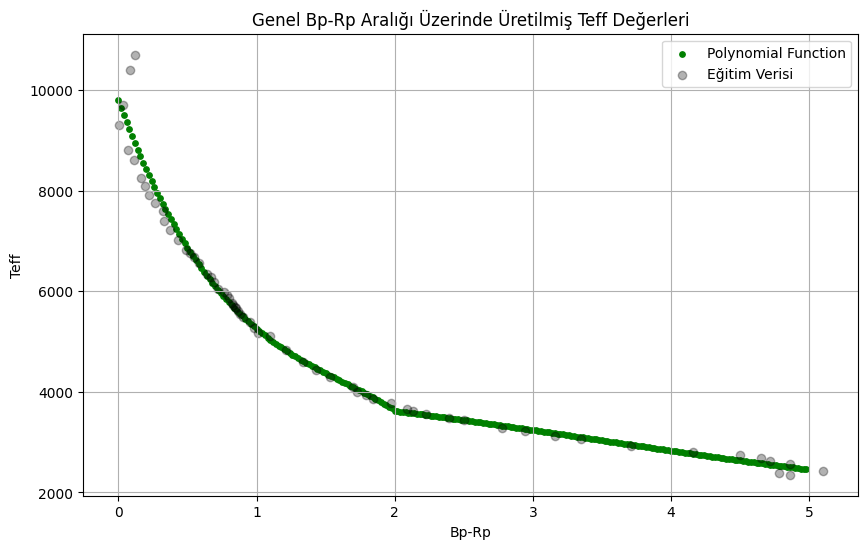

In [ ]:
#Yukarıdaki tablonun grafiksel çizimi
plt.figure(figsize=(10, 6))
plt.scatter(bp_rp_new, teff_new, label="Polynomial Function", color='green',s=15)
plt.scatter(x, y, alpha=0.3, label="Eğitim Verisi", color='black')
plt.xlabel("Bp-Rp")
plt.ylabel("Teff")
plt.title("Genel Bp-Rp Aralığı Üzerinde Üretilmiş Teff Değerleri")
plt.grid(True)
plt.legend()
plt.show()


sample: 100%|██████████| 12000/12000 [00:54<00:00, 220.66it/s, 1023 steps of size 1.16e-03. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.16      0.02      0.16      0.13      0.18    628.90      1.00
      w[0]      2.08      0.07      2.08      1.96      2.21    215.75      1.00
      w[1]     -3.62      0.34     -3.60     -4.16     -3.07    133.58      1.01
      w[2]      1.97      0.47      1.95      1.22      2.76    122.60      1.01
      w[3]     -0.61      0.26     -0.60     -1.01     -0.16    122.77      1.01
      w[4]      0.10      0.06      0.09     -0.01      0.19    126.55      1.01
      w[5]     -0.01      0.00     -0.01     -0.01      0.00    132.27      1.01

Number of divergences: 0


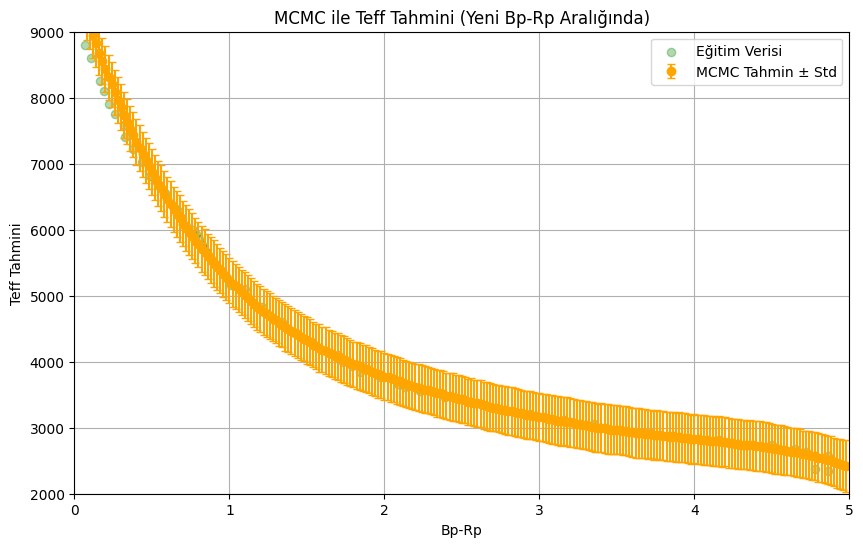

In [52]:
"""
================= MCMC ile Teff Tahmini =================
Bu kısımda da yine aynı şekilde MCMC ile teff tahmini yapılmıştır.
"""

scaler = StandardScaler()
x_scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 1)).flatten()
bprp_scaled = scaler.transform(bprp_values.reshape(-1, 1)).flatten()

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()


x_train_vander = np.vander(x_scaled, 3, increasing=True)
x_train_jax = jnp.array(x_train_vander)

x_test_vander = np.vander(bprp_scaled, n_order + 1, increasing=True)
x_test_jax = jnp.array(x_test_vander)

def model(X, Y=None):
    n_features = X.shape[1]
    w = numpyro.sample("w", dist.Normal(0, 10).expand([n_features]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10.0))
    mean = jnp.dot(X, w)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(mean, sigma), obs=Y)


x_train_vander = np.vander(x, n_order + 1, increasing=True)
x_train_jax = jnp.array(x_train_vander)
y_train_jax = jnp.array(y_scaled)


nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=6000, num_samples=6000)
mcmc.run(jax.random.PRNGKey(0), X=x_train_jax, Y=y_train_jax)
mcmc.print_summary()


x_test_vander = np.vander(bp_rp_new, n_order + 1, increasing=True)
x_test_jax = jnp.array(x_test_vander)


predictive = Predictive(model, posterior_samples=mcmc.get_samples(), return_sites=["obs"])
predictions = predictive(jax.random.PRNGKey(1), X=x_test_jax)
teff_samples = predictions["obs"]


mean_pred_scaled = np.mean(teff_samples, axis=0)
std_pred_scaled = np.std(teff_samples, axis=0)

mean_pred = y_scaler.inverse_transform(mean_pred_scaled.reshape(-1, 1)).flatten()
std_pred = std_pred_scaled * y_scaler.scale_[0]



df_sent["teffTahminleri_MCMC"] = mean_pred
df_sent["stdSapma"] = std_pred
std_pred

plt.figure(figsize=(10, 6))
plt.errorbar(df_sent["Bp-Rp"], mean_pred, yerr=std_pred,
             fmt='o', label="MCMC Tahmin ± Std", color='orange', capsize=3)
plt.xlabel("Bp-Rp")
plt.scatter(x, y, alpha=0.3, label="Eğitim Verisi", color='green')
plt.ylabel("Teff Tahmini")
plt.title("MCMC ile Teff Tahmini (Yeni Bp-Rp Aralığında)")
plt.legend()
plt.grid(True)
plt.xlim(0, 5.0)
plt.ylim(2000, 9000)
plt.show()




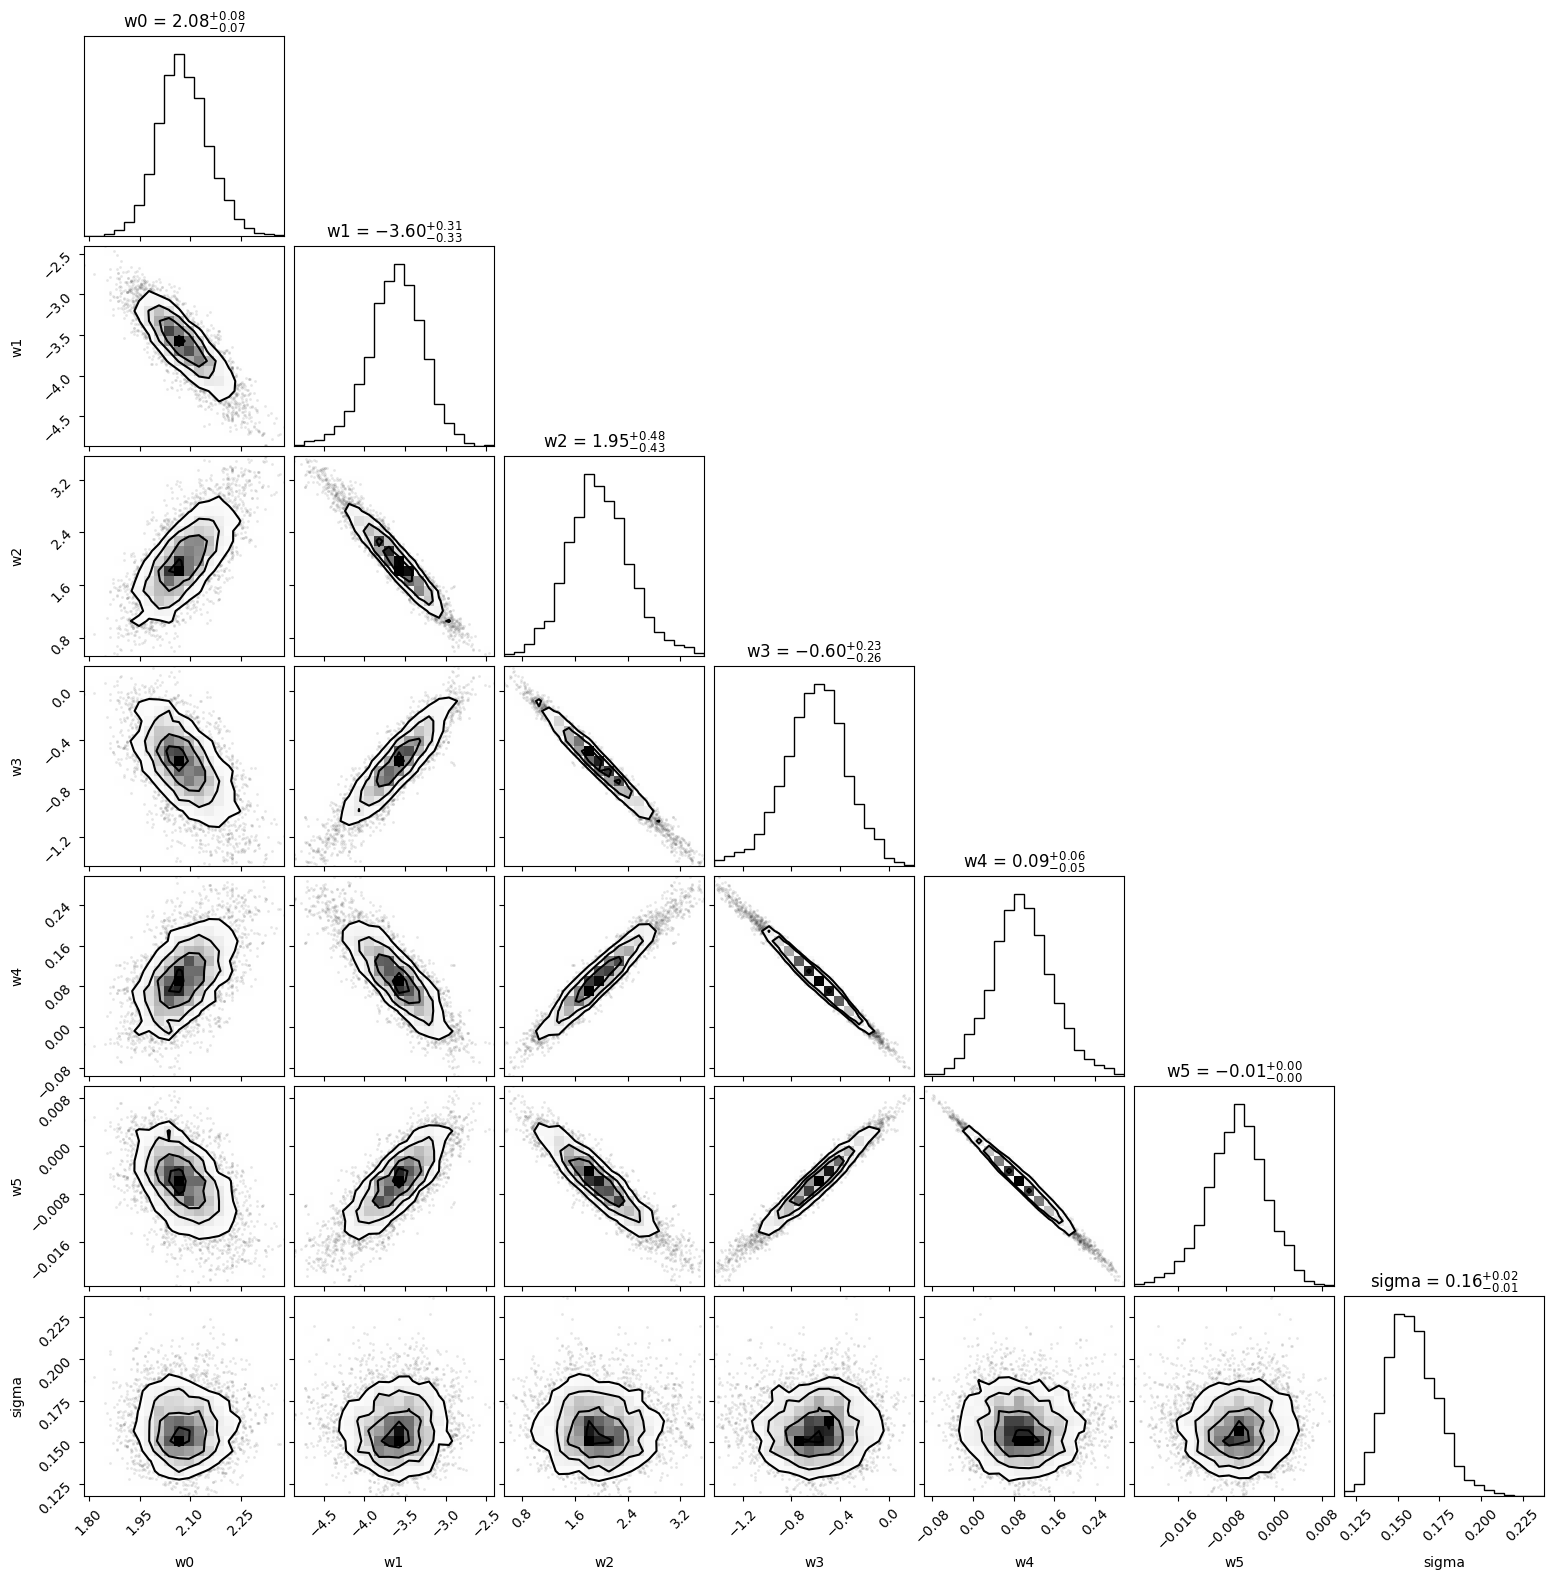

In [53]:
"""
================= MCMC POSTERIOR GÖRSELLEŞTİRME =================

- NumPyro MCMC çıktısından (mcmc) alınan posterior örnekleriyle
  parametre marjinal dağılımlarını (histogram) ve ikili ortak dağılımları
  (contour) corner plot ile görselleştirilmiştir.
"""
samples_dict=mcmc.get_samples()

param_array = np.column_stack([samples_dict["w"][:, i] for i in range(samples_dict["w"].shape[1])] + [samples_dict["sigma"]])
labels = [f"w{i}" for i in range(samples_dict["w"].shape[1])] + ["sigma"]

fig = corner.corner(
    param_array,
    labels=labels,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=None
)
plt.show()

In [ ]:
"""
================= MCMC Tahminleri ile Gerçek Eğitim Verilerinin Karşılaştırlımlası =================
-MCMC modelinden elde edilen tahminleri gerçek eğitim verileriyle karşılaştırılıp, satır satır hata tablosu çıkartılmıştır
"""
from scipy.interpolate import interp1d

interp_func = interp1d(df_sent["Bp-Rp"], df_sent["teffTahminleri_MCMC"],
                       bounds_error=False, fill_value="extrapolate")

teff_tahmin_edilen = interp_func(x)

hatalar = y - teff_tahmin_edilen

df_hatalar = pd.DataFrame({
    "Bp-Rp": x,
    "Gerçek_Teff": y,
    "Model_Teff": teff_tahmin_edilen,
    "Hata (Gerçek - Tahmin)": hatalar
})

mae = mean_absolute_error(y, teff_tahmin_edilen)
rmse = np.sqrt(mean_squared_error(y, teff_tahmin_edilen))


print("\n--- Hata Tablosu ---")
display(df_hatalar)




--- Hata Tablosu ---


,Bp-Rp,Gerçek_Teff,Model_Teff,Hata (Gerçek - Tahmin)
0,0.120,10700,8822.846680,1877.153320
1,0.087,10400,9007.087109,1392.912891
2,0.037,9700,9274.805957,425.194043
3,0.005,9300,9465.519043,-165.519043
4,0.068,8800,9117.663281,-317.663281
...,...,...,...,...
58,4.720,2630,2623.714844,6.285156
59,4.860,2570,2427.302002,142.697998
60,5.100,2420,2048.230713,371.769287
61,4.780,2380,2553.970215,-173.970215
